In [45]:
from data import Data
import numpy as np
from matplotlib import pyplot as plt

In [14]:
d = Data()
X_train,y_train = d.get_10()
X_cross, y_cross = d.get_dev()
X_test,y_test = d.get_test()

Attempting to load from cached pkl object.
success.


In [15]:
# X_train = X_train
# y_train = y_train
print(X_train.shape)
print(y_train.shape)
print(X_cross.shape)
print(y_cross.shape)
print(X_test.shape)
print(y_test.shape)

(742, 48, 64, 3)
(742,)
(3230, 48, 64, 3)
(3230,)
(2423, 48, 64, 3)
(2423,)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [17]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        img = self.X[index]
        label = self.y[index]
        return (img, label)

    def __len__(self):
        return self.X.shape[0]

In [18]:
NUM_TRAIN = X_train.shape[0]
train_dataset = MyCustomDataset(X_train, y_train)
loader_train = DataLoader(train_dataset, batch_size=10,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

test_dataset = MyCustomDataset(X_test, y_test)
loader_test = DataLoader(test_dataset, batch_size=10)


In [19]:
def flatten(X):
    N = X.shape[0]
    return X.view(N,-1)

In [20]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(Variable(x.float()))
            _, preds = scores.max(1)
            num_correct += (preds == Variable(y.long())).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [78]:
print_every = 10
def train(model, optimizer, epochs=15):
    loss_arr = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            scores = model(Variable(x.float()))
            loss = F.cross_entropy(scores, Variable(y.long()))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss))
                loss_arr += [loss.item()]
                check_accuracy(loader_train, model)
    return loss_arr

In [79]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

Iteration 0, loss = 48.7506
Got 92 / 742 correct (12.40)
Iteration 10, loss = 48.1523
Got 102 / 742 correct (13.75)
Iteration 20, loss = 42.6194
Got 106 / 742 correct (14.29)
Iteration 30, loss = 36.8039
Got 161 / 742 correct (21.70)
Iteration 40, loss = 10.3215
Got 182 / 742 correct (24.53)
Iteration 50, loss = 20.7367
Got 166 / 742 correct (22.37)
Iteration 60, loss = 8.1544
Got 121 / 742 correct (16.31)
Iteration 70, loss = 22.0234
Got 103 / 742 correct (13.88)
Iteration 0, loss = 15.9778
Got 133 / 742 correct (17.92)
Iteration 10, loss = 13.1197
Got 158 / 742 correct (21.29)
Iteration 20, loss = 20.6144
Got 163 / 742 correct (21.97)
Iteration 30, loss = 6.7645
Got 178 / 742 correct (23.99)
Iteration 40, loss = 17.1659
Got 222 / 742 correct (29.92)
Iteration 50, loss = 8.9462
Got 205 / 742 correct (27.63)
Iteration 60, loss = 10.3022
Got 194 / 742 correct (26.15)
Iteration 70, loss = 4.9039
Got 214 / 742 correct (28.84)
Iteration 0, loss = 9.0333
Got 181 / 742 correct (24.39)
Iterat

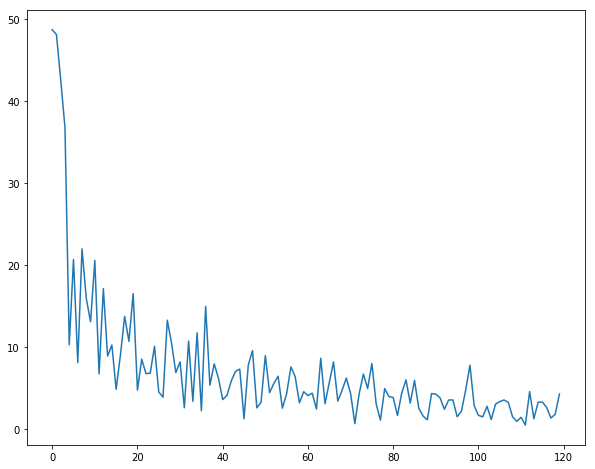

In [80]:
hidden_layer_size = 500
learning_rate = 5e-5
num_classes = 10

model = nn.Sequential(
    Flatten(),
    nn.Linear(3*48*64,hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size,num_classes)
    )
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_arr = train(model,optimizer)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.plot(loss_arr)
plt.show()